<a href="https://colab.research.google.com/github/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/module02_03_hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizers, Data Partitioning, Finding Good Parameters


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.version

'3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC v.1941 64 bit (AMD64)]'

When discussing Adam, we discussed how we can create a single vector of weight values. We also saw how to view parts of that single vector to define the weight matrices for each layer of a neural network (say, $V$ and $W$).  Here is a function that will do that automatically, given a list of shapes of the matrices of weights for each layer.

In [3]:
# create a random 3x3 sample
sample = np.random.uniform(size=(3,3))
sample

array([[0.61787554, 0.83433203, 0.77380855],
       [0.12464437, 0.49610152, 0.57806312],
       [0.68729789, 0.85529071, 0.60762713]])

In [4]:
# let's view it flattened
sample.flat

In [5]:
# oops, ndarray.flat returns an iterator, so we have to slice it
sample.flat[:]

array([0.61787554, 0.83433203, 0.77380855, 0.12464437, 0.49610152,
       0.57806312, 0.68729789, 0.85529071, 0.60762713])

In [6]:
def make_weights_and_views(shapes):
    # vector of all weights built by horizontally stacking flattened matrices
    # for each layer initialized with uniformly-distributed values.
    all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                             for shape in shapes])
    # Build list of views by reshaping corresponding elements from vector of all weights
    # into correct shape for each layer.
    views = []
    start = 0
    for shape in shapes:
        size = shape[0] * shape[1]
        views.append(all_weights[start:start + size].reshape(shape))
        start += size
    return all_weights, views

What would the shapes of the weight matrices be of a neural network with 2 inputs, 2 hidden layers with 20 and 10 units, respectively, and 1 output?

In [7]:
n_in = 2 # number of inputs
n_hiddens_per_layer = [20,10] # number of hidden units per layer
n_out = 1 # number of outputs
shapes = [] # init empty list
for nh in n_hiddens_per_layer:
    # for each layer
    shapes.append((n_in + 1, nh)) # append (1 + number of inputs, number of units in this layer)
    # why do we use 1 + n_in?
    n_in = nh # now the number of inputs (to the next layer) is the number of units in this layer
    # why is that?
shapes.append((n_in + 1, n_out)) # append (1 + number of inputs, number of units in this layer a.k.a. number of outputs)

shapes

[(3, 20), (21, 10), (11, 1)]

NOTE:

Extra 1 comes from adding bias to input of each layer

In [8]:
make_weights_and_views(shapes)

(array([0.18217573, 0.22240906, 0.16830699, 0.40874453, 0.236937  ,
        0.36112286, 0.37091233, 0.1806741 , 0.09934893, 0.0137453 ,
        0.38554996, 0.31048633, 0.22614747, 0.31929968, 0.32229477,
        0.32896191, 0.33265045, 0.56676714, 0.35945125, 0.54949057,
        0.44695778, 0.41163793, 0.39642393, 0.17269211, 0.08176132,
        0.10838901, 0.20280092, 0.03601346, 0.05184677, 0.01097436,
        0.41394505, 0.05626691, 0.07024555, 0.27555168, 0.39411752,
        0.03986271, 0.3575505 , 0.57260173, 0.0913614 , 0.21766336,
        0.55438864, 0.1272271 , 0.4332041 , 0.56910521, 0.04337204,
        0.09622148, 0.49890854, 0.47999971, 0.37304011, 0.23364958,
        0.558124  , 0.06822357, 0.51516187, 0.45427956, 0.53920863,
        0.07919489, 0.10634576, 0.52045369, 0.33023548, 0.01598448,
        0.00339297, 0.03291868, 0.01612924, 0.09896584, 0.12904192,
        0.1398084 , 0.13696443, 0.00481554, 0.04588044, 0.02289087,
        0.17614077, 0.0788413 , 0.13537672, 0.13

Now let's make some data with 2 inputs per sample and 1 target output.  We can have fun with this by making our target values the height of several hills over the 2-dimensional base plane of input values.

In [9]:
centers = np.array([[2,2], [5,4], [8,2], [9,8], [3,7]]) # 2D locations of the center of each hill
heights = np.array([5, 4, 5, 7, 4]) # height of each hill

In [10]:
def calc_heights(X, center):
    diffv = X - center # vertical difference = mesh - height of this center
    return np.exp(-np.sum(diffv * diffv, axis=1)).reshape(-1, 1) # e^-Σdiffv^2

In [11]:
np.meshgrid?

Signature:       np.meshgrid(*xi, copy=True, sparse=False, indexing='xy')
Call signature:  np.meshgrid(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function meshgrid at 0x000001C57FD97A60>
File:            c:\users\evan\appdata\roaming\python\python313\site-packages\numpy\lib\_function_base_impl.py
Docstring:      
Return a tuple of coordinate matrices from coordinate vectors.

Make N-D coordinate arrays for vectorized evaluations of
N-D scalar/vector fields over N-D grids, given
one-dimensional coordinate arrays x1, x2,..., xn.

.. versionchanged:: 1.9
   1-D and 0-D cases are allowed.

Parameters
----------
x1, x2,..., xn : array_like
    1-D arrays representing the coordinates of a grid.
indexing : {'xy', 'ij'}, optional
    Cartesian ('xy', default) or matrix ('ij') indexing of output.
    See Notes for more details.

    .. versionadded:: 1.7.0
sparse : bool, optional
    If True the shape of the returned coordinate array for dimension *i*
    is re

In [12]:
# two evenly-spaced lines
X_1 = np.linspace(0,10, 20)
X_2 = np.linspace(0,10, 20)

# make a grid out of these two arrays
X_1_mesh, X_2_mesh = np.meshgrid(X_1, X_2)
print(X_1_mesh.shape, X_2_mesh.shape)

X = np.hstack((X_1_mesh.reshape((-1, 1)), X_2_mesh.reshape((-1, 1))))
print(X.shape)

# now X shows the coordinates of every points in this 2D grid
print(X)

(20, 20) (20, 20)
(400, 2)
[[ 0.          0.        ]
 [ 0.52631579  0.        ]
 [ 1.05263158  0.        ]
 [ 1.57894737  0.        ]
 [ 2.10526316  0.        ]
 [ 2.63157895  0.        ]
 [ 3.15789474  0.        ]
 [ 3.68421053  0.        ]
 [ 4.21052632  0.        ]
 [ 4.73684211  0.        ]
 [ 5.26315789  0.        ]
 [ 5.78947368  0.        ]
 [ 6.31578947  0.        ]
 [ 6.84210526  0.        ]
 [ 7.36842105  0.        ]
 [ 7.89473684  0.        ]
 [ 8.42105263  0.        ]
 [ 8.94736842  0.        ]
 [ 9.47368421  0.        ]
 [10.          0.        ]
 [ 0.          0.52631579]
 [ 0.52631579  0.52631579]
 [ 1.05263158  0.52631579]
 [ 1.57894737  0.52631579]
 [ 2.10526316  0.52631579]
 [ 2.63157895  0.52631579]
 [ 3.15789474  0.52631579]
 [ 3.68421053  0.52631579]
 [ 4.21052632  0.52631579]
 [ 4.73684211  0.52631579]
 [ 5.26315789  0.52631579]
 [ 5.78947368  0.52631579]
 [ 6.31578947  0.52631579]
 [ 6.84210526  0.52631579]
 [ 7.36842105  0.52631579]
 [ 7.89473684  0.52631579]
 

In [13]:
h = calc_heights(X, centers[0])
h.shape, h # this is now the height of each point in the grid
# what would np.hstack((X,h) produce?

((400, 1),
 array([[3.35462628e-04],
        [2.08758966e-03],
        [7.46517112e-03],
        [1.53400946e-02],
        [1.81138157e-02],
        [1.22909511e-02],
        [4.79241786e-03],
        [1.07378542e-03],
        [1.38252810e-04],
        [1.02287855e-05],
        [4.34878374e-07],
        [1.06244190e-08],
        [1.49154448e-10],
        [1.20326385e-12],
        [5.57800841e-15],
        [1.48590519e-17],
        [2.27455621e-20],
        [2.00076411e-23],
        [1.01132033e-26],
        [2.93748211e-30],
        [2.08758966e-03],
        [1.29911061e-02],
        [4.64558873e-02],
        [9.54616702e-02],
        [1.12722584e-01],
        [7.64867987e-02],
        [2.98232981e-02],
        [6.68218500e-03],
        [8.60349595e-04],
        [6.36539064e-05],
        [2.70625554e-06],
        [6.61159409e-08],
        [9.28190677e-10],
        [7.48793145e-12],
        [3.47120415e-14],
        [9.24681336e-17],
        [1.41546021e-19],
        [1.24507892e-22],
 

Let's visualize these points.

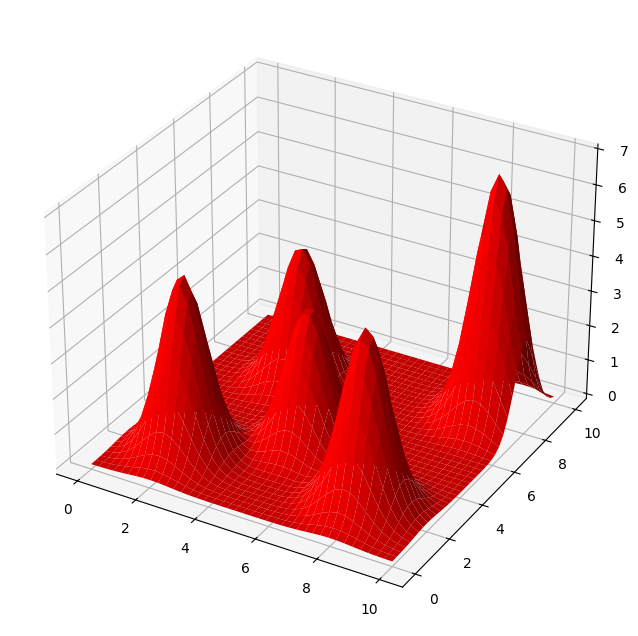

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# same as above but now creating n points per side
n = 40 # play with this
X_1 = np.linspace(0, 10, n)
X_2 = np.linspace(0, 10, n)

X_1_mesh, X_2_mesh = np.meshgrid(X_1, X_2)
X = np.hstack((X_1_mesh.reshape((-1, 1)), X_2_mesh.reshape((-1, 1)))) # make the base mesh
Z = np.zeros((X.shape[0], 1))
for hilli in range(len(heights)):
    Z += calc_heights(X, centers[hilli]) * heights[hilli] # Z now represents the height
Z_mesh = Z.reshape(n, n)

surf = ax.plot_surface(X_1_mesh, X_2_mesh, Z_mesh, rstride=1, cstride=1, color='red', linewidth=0);

Or, how about some more realistic lighting? See these [examples of using LightSource](http://physicalmodelingwithpython.blogspot.com/2015/08/illuminating-surface-plots.html).

In [15]:
from matplotlib.colors import LightSource
LightSource?

Init signature:
LightSource(
    azdeg=315,
    altdeg=45,
    hsv_min_val=0,
    hsv_max_val=1,
    hsv_min_sat=1,
    hsv_max_sat=0,
)
Docstring:     
Create a light source coming from the specified azimuth and elevation.
Angles are in degrees, with the azimuth measured
clockwise from north and elevation up from the zero plane of the surface.

`shade` is used to produce "shaded" RGB values for a data array.
`shade_rgb` can be used to combine an RGB image with an elevation map.
`hillshade` produces an illumination map of a surface.
Init docstring:
Specify the azimuth (measured clockwise from south) and altitude
(measured up from the plane of the surface) of the light source
in degrees.

Parameters
----------
azdeg : float, default: 315 degrees (from the northwest)
    The azimuth (0-360, degrees clockwise from North) of the light
    source.
altdeg : float, default: 45 degrees
    The altitude (0-90, degrees up from horizontal) of the light
    source.
hsv_min_val : number, default: 0

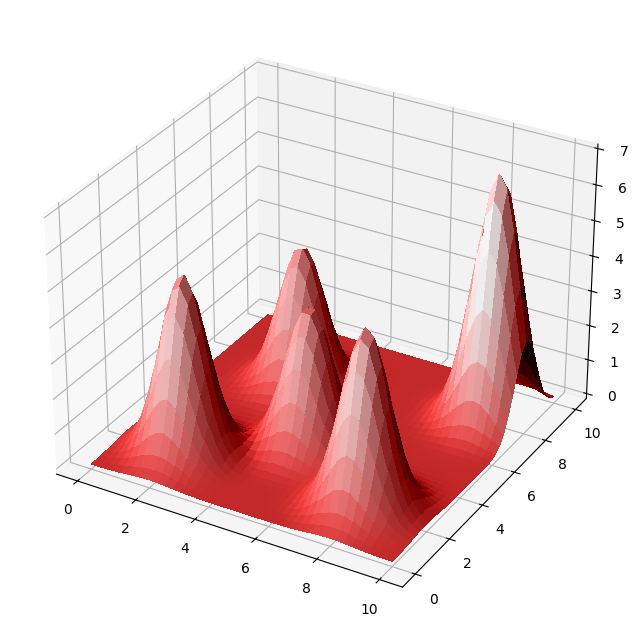

In [16]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

white = np.ones((Z_mesh.shape[0], Z_mesh.shape[1], 3))
red = white * np.array([1, 0, 0])
green = white * np.array([0, 1, 0])
blue = white * np.array([0, 0, 1])

ls = LightSource(azdeg=-20, altdeg=70)

rgb = ls.shade_rgb(red, Z_mesh, vert_exag=0.1) #, blend_mode='soft')

surf = ax.plot_surface(X_1_mesh, X_2_mesh, Z_mesh, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=True)

Now we can make some data.  `X` is our base plane points, which will be the inputs.  The target values for `T` are the heights.

In [27]:
T = Z
X.shape, T.shape

((1600, 2), (1600, 1))

NOTE:

Data visualization is a useful skill to have

## Train, validate, test

Before trying to fit this data with our neural network model, let's discuss how to partition data into training, validation and testing.  Steps involved are:
1. shuffle the samples into a random order,
2. partition the data into $n$ folds,
4. assign the first fold to the validation set,
5. assign the second fold to the testing set, and
3. collect the third through the last folds into a training set.

In [ ]:
# same as above but now creating n points per side
n = 40 # play with this
X_1 = np.linspace(0, 10, n)
X_2 = np.linspace(0, 10, n)

X_1_mesh, X_2_mesh = np.meshgrid(X_1, X_2)
X = np.hstack((X_1_mesh.reshape((-1, 1)), X_2_mesh.reshape((-1, 1)))) # make the base mesh
Z = np.zeros((X.shape[0], 1))
for hilli in range(len(heights)):
    Z += calc_heights(X, centers[hilli]) * heights[hilli] # Z now represents the height
Z_mesh = Z.reshape(n, n)

T = Z


np.random.seed(42)
rows = np.arange(X.shape[0])
np.random.shuffle(rows)
print(rows)

X = X[rows, :]
T = T[rows, :]


[ 526  354  168 ...  860 1459 1126]


In [48]:
rows = np.arange(X.shape[0])
np.random.shuffle(rows)  # shuffle the row indices in-place (rows is changed)
X = X[rows, :]
T = T[rows, :]

n_folds = 5
n_samples = X.shape[0]
n_per_fold = n_samples // n_folds # double-slash = "floor division" which rounds down to the nearest number
n_last_fold = n_samples - n_per_fold * (n_folds - 1)  # handles case when n_samples not evenly divided by n_folds

folds = []
start = 0
for foldi in range(n_folds-1):
    folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
    start += n_per_fold
folds.append( (X[start:, :], T[start:, :]) )   # Changed in notes 07.2
len(folds), len(folds[0]), folds[0][0].shape, folds[0][1].shape

(5, 2, (320, 2), (320, 1))

In [46]:
Xvalidate, Tvalidate = folds[0]
Xtest, Ttest = folds[1]
Xtrain, Ttrain = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]]) # what is this doing? Hint: look at [2:]
Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape, Xtest.shape, Ttest.shape

((960, 2), (960, 1), (320, 2), (320, 1), (320, 2), (320, 1))

Once you have completed the `NeuralNetwork` class definition in assignment A2, you can use it like this. Assume you have saved your `NeuralNetwork` class in a file named `neuralnetwork.py` (not required for the assignment).

In [20]:
import neuralnetwork as nn
print(X.shape[1])
print(T.shape[1])

ModuleNotFoundError: No module named 'neuralnetwork'

In [ ]:
nnet = nn.NeuralNetwork(X.shape[1], [10, 5], T.shape[1])
nnet

AttributeError: module 'neuralnetwork' has no attribute 'NeuralNetwork'

In [ ]:
nnet.train(Xtrain, Ttrain, n_epochs=10000, learning_rate=0.01, method='sgd')

Epoch 1000: RMSE 0.964
Epoch 2000: RMSE 0.914
Epoch 3000: RMSE 0.806
Epoch 4000: RMSE 0.705
Epoch 5000: RMSE 0.675
Epoch 6000: RMSE 0.651
Epoch 7000: RMSE 0.631
Epoch 8000: RMSE 0.613
Epoch 9000: RMSE 0.594
Epoch 10000: RMSE 0.569


Epoch 1000: RMSE 0.223
Epoch 2000: RMSE 0.187
Epoch 3000: RMSE 0.175
Epoch 4000: RMSE 0.160
Epoch 5000: RMSE 0.156
Epoch 6000: RMSE 0.153
Epoch 7000: RMSE 0.151
Epoch 8000: RMSE 0.150
Epoch 9000: RMSE 0.148
Epoch 10000: RMSE 0.158
Training took 10.26 seconds.


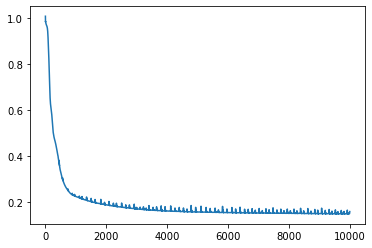

In [ ]:
import time

startTime = time.time()

nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 5], Ttrain.shape[1])
nnet.train(Xtrain, Ttrain, n_epochs=10000, learning_rate=0.01, method='adam')

print('Training took {:.2f} seconds.'.format(time.time()-startTime))

plt.plot(nnet.error_trace);

In [ ]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

In [ ]:
nnet.use(Xtrain).shape

(960, 1)

In [ ]:
print(f'RMSE Training {rmse(Ttrain, nnet.use(Xtrain)):.3f}')
print(f'RMSE Validation {rmse(Tvalidate, nnet.use(Xvalidate)):.3f}')
print(f'RMSE Testing {rmse(Ttest, nnet.use(Xtest)):.3f}')

RMSE Training 0.185
RMSE Validation 0.213
RMSE Testing 0.226


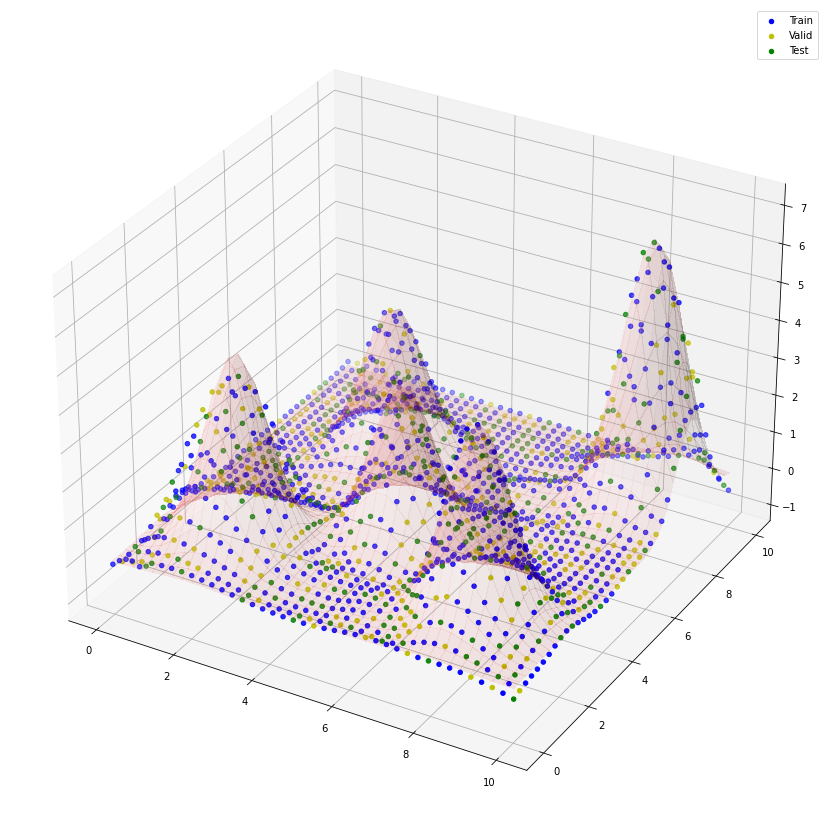

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

white = np.ones((Z_mesh.shape[0], Z_mesh.shape[1], 3))
red = white * np.array([1, 0, 0])
green = white * np.array([0, 1, 0])
blue = white * np.array([0, 0, 1])

ls = LightSource(azdeg=-20, altdeg=70)

rgb = ls.shade_rgb(red, Z_mesh, vert_exag=0.1) #, blend_mode='soft')

surf = ax.plot_surface(X_1_mesh, X_2_mesh, Z_mesh, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=True, alpha=0.1)  # alpha < 1 is transparent

Ytrain = nnet.use(Xtrain)
ax.scatter(Xtrain[:, 0], Xtrain[:, 1], Ytrain, c='b', marker='o', label='Train')

Yvalidate = nnet.use(Xvalidate)
ax.scatter(Xvalidate[:, 0], Xvalidate[:, 1], Yvalidate, c='y', marker='o', label='Valid')

Ytest = nnet.use(Xtest)
ax.scatter(Xtest[:, 0], Xtest[:, 1], Ytest, c='g', marker='o', label='Test')

#ax.scatter(X[:, 0], X[:, 1], T, c='r', marker='o', label='Target')

plt.legend();

Can we visualize what the hidden units have learned, like we did for data sets with a single variable input?

Sure.  Just plot a unit's output as a surface over the base plane of input values.

In [ ]:
import torch

# run just the forward pass
# here we use pytorch
# THIS IS NOT NECESSARY FOR ASSIGNMENT 2
def forward_pass(nnet, X):
        # we want to append the outputs of every layer
        # so we can examine what each weight's gradient looks like
        Ys = [X] # <-- make it a list
        for hidden_layer in nnet.hidden_layers:
            # below: hidden_layer(X) runs the layer
            # the input to hidden_layer should be the last set of outputs (Ys[-1])
            # torch.from_numpy converts ndarray to tensor (expects things to be float32s)
            # running the layer returns a tensor, .detach().cpu().numpy() converts it back to an ndarray
            Ys.append(hidden_layer(torch.from_numpy(Ys[-1].astype(np.float32))).detach().cpu().numpy())
        Ys.append(nnet.output_layer(torch.from_numpy(Ys[-1])))
        return Ys

<Figure size 1800x1800 with 0 Axes>

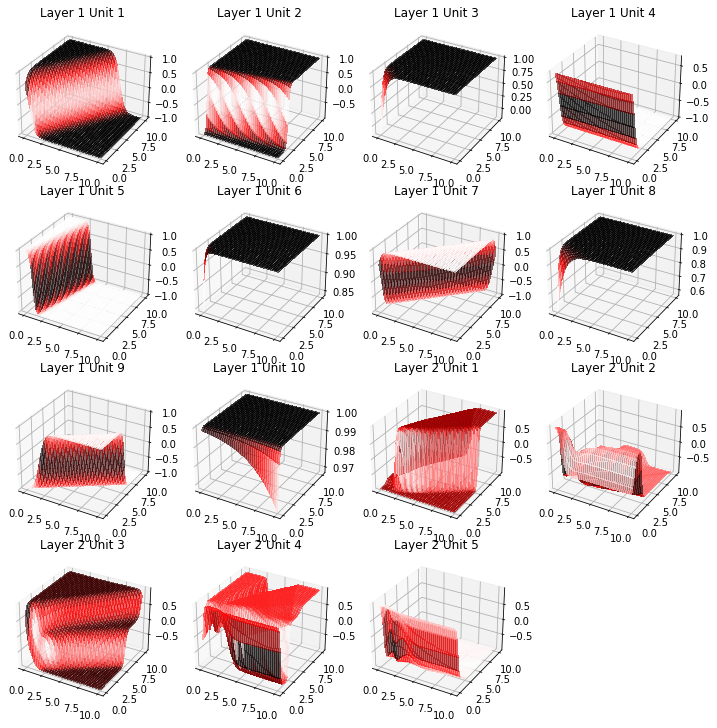

In [ ]:
plt.figure(figsize=(25, 25))

nPlot = 40
Xplot = np.linspace(0, 10, nPlot)
Yplot = np.linspace(0, 10, nPlot)
Xplot, Yplot = np.meshgrid(Xplot, Yplot)
XYplot = np.hstack((Xplot.reshape((-1, 1)), Yplot.reshape((-1, 1))))
white = np.ones((Xplot.shape[0], Xplot.shape[1], 3))
red = white * np.array([1, 0, 0])

Ys = forward_pass(nnet,XYplot)
Ys = Ys[1:]  # to remove inputs

nUnits = sum(nnet.n_hiddens_per_layer)
nPlotsSqroot = int(np.sqrt(nUnits))
if nPlotsSqroot**2 <= nUnits:
    nPlotsSqroot += 1

ls = LightSource(azdeg=-20, altdeg=70)

# ls = LightSource(azdeg=90, altdeg=80)
white = np.ones((Xplot.shape[0], Xplot.shape[1], 3))
red = white * np.array([1, 0, 0])

fig = plt.figure(figsize=(10, 10))
ploti = 0
surfaces = []
for layeri in range(len(nnet.n_hiddens_per_layer)):
    for uniti in range(nnet.n_hiddens_per_layer[layeri]):
        ploti += 1
        ax = fig.add_subplot(nPlotsSqroot, nPlotsSqroot, ploti, projection='3d')
        Yunit = Ys[layeri][:, uniti].reshape(Xplot.shape)
        rgbPredicted = ls.shade_rgb(red, Yunit, vert_exag=0.1)
        surfaces.append( ax.plot_surface(Xplot, Yplot, Yunit, rstride=1, cstride=1,
                                         facecolors=rgbPredicted,
                                         linewidth=0, antialiased=False, shade=False, alpha=0.6 ) )
        plt.title('Layer {:d} Unit {:d}'.format(layeri + 1, uniti + 1))

plt.tight_layout();

Now, let's investigate effects of various parameters. Let's try different training durations, hidden later structures, and optimizers.  We'll train with each possible combination, then plot the results.

Each of these things we're now varying are called **hyperparameters** (this is not to be confused with *parameters*, which in ML usually refers to trainable weights.  When you hear about a "1B parameter model," that's one that has **one billion** trained weight values.

"Parameters" refer to weights.  "Hyperparameters" are properties of the architecture.

In [ ]:
import pandas

results = []
for rate in [0.01]: # learning rates
    for epochs in [1000, 5000]: # Training durations
        for nh in [[0], [10], [50, 10]]: # Layer sizes
            for method in ['adam', 'sgd']: # Optimizers
                # instantiate and train
                nnet = nn.NeuralNetwork(Xtrain.shape[1], nh, Ttrain.shape[1])
                nnet.train(Xtrain, Ttrain, epochs, rate, method=method)
                # append the results of each experiment
                results.append([rate, epochs, nh, method,
                                rmse(Ttrain, nnet.use(Xtrain)),
                                rmse(Tvalidate, nnet.use(Xvalidate)),
                                rmse(Ttest, nnet.use(Xtest))])
                # load these into a dataframe and give it some column titles
                df = pandas.DataFrame(results, columns=('rate', 'epochs', 'nh', 'method', 'train RMSE',
                                                    'validate RMSE', 'test RMSE'))
            print(df)

Epoch 100: RMSE 0.984
Epoch 200: RMSE 0.984
Epoch 300: RMSE 0.984
Epoch 400: RMSE 0.984
Epoch 500: RMSE 0.984
Epoch 600: RMSE 0.984
Epoch 700: RMSE 0.984
Epoch 800: RMSE 0.984
Epoch 900: RMSE 0.984
Epoch 1000: RMSE 0.984
Epoch 100: RMSE 0.984
Epoch 200: RMSE 0.984
Epoch 300: RMSE 0.984
Epoch 400: RMSE 0.984
Epoch 500: RMSE 0.984
Epoch 600: RMSE 0.984
Epoch 700: RMSE 0.984
Epoch 800: RMSE 0.984
Epoch 900: RMSE 0.984
Epoch 1000: RMSE 0.984
   rate  epochs   nh method  train RMSE  validate RMSE  test RMSE
0  0.01    1000  [0]   adam    1.165921       1.094978   1.264666
1  0.01    1000  [0]    sgd    1.165921       1.094978   1.264666
Epoch 100: RMSE 0.952
Epoch 200: RMSE 0.780
Epoch 300: RMSE 0.641
Epoch 400: RMSE 0.588
Epoch 500: RMSE 0.567
Epoch 600: RMSE 0.551
Epoch 700: RMSE 0.538
Epoch 800: RMSE 0.530
Epoch 900: RMSE 0.525
Epoch 1000: RMSE 0.523
Epoch 100: RMSE 0.978
Epoch 200: RMSE 0.976
Epoch 300: RMSE 0.972
Epoch 400: RMSE 0.969
Epoch 500: RMSE 0.965
Epoch 600: RMSE 0.961
Epoch 7

Now, which parameter values are best?

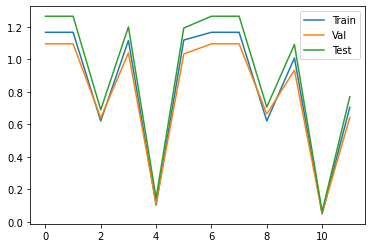

In [ ]:
plt.plot(df[['train RMSE', 'validate RMSE', 'test RMSE']])
plt.legend(('Train', 'Val', 'Test'))

Not very helpful.  We need to plot with respect to different hyperparameter values.

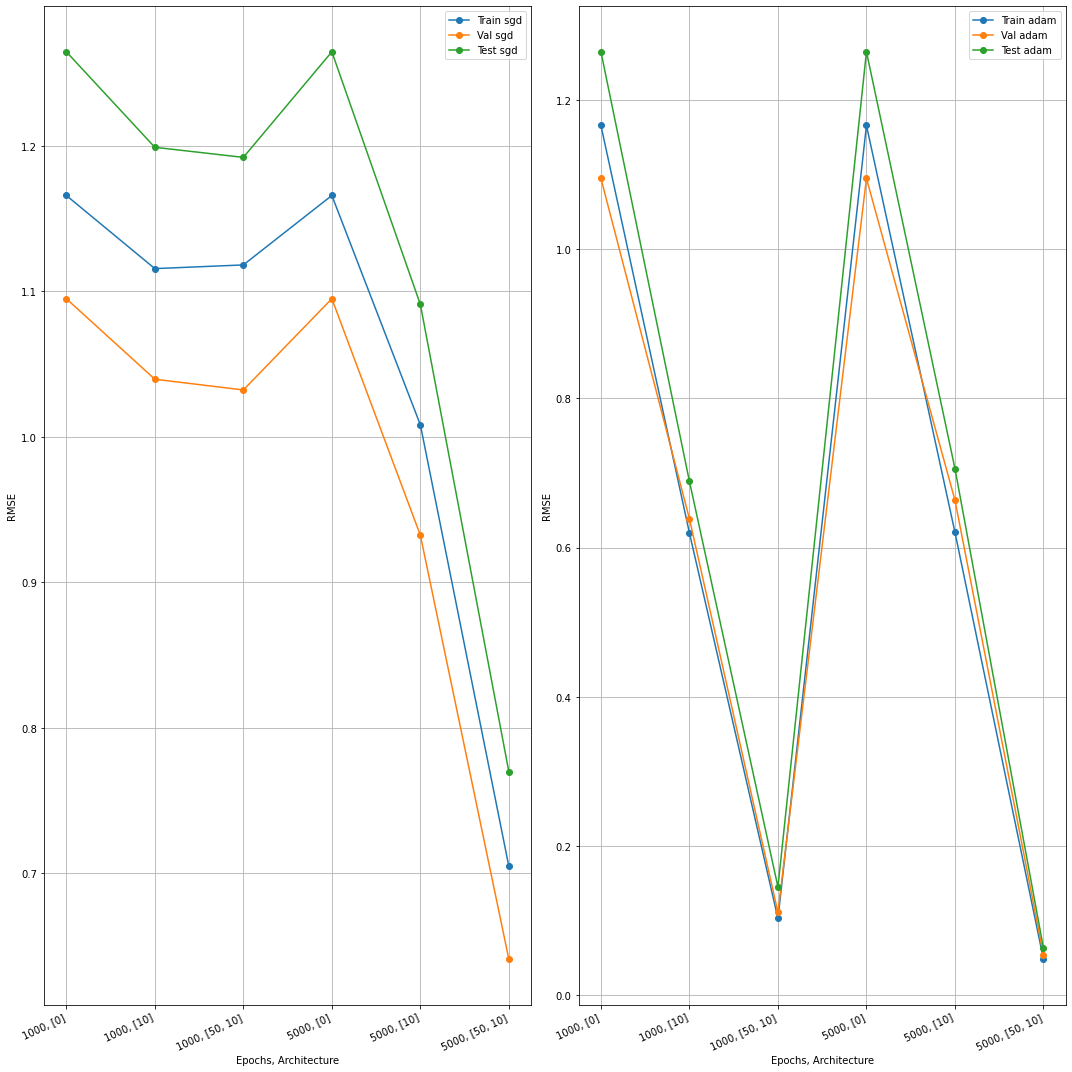

In [ ]:
plt.figure(figsize=(15, 15))

# we'll plot two graphs of RMSE on the Y-axis vs. our training durations and architectures on the X-axis

# plot results with SGD optmization on the left
plt.subplot(1, 2, 1)
dfsgd = df[(df['method'] == 'sgd')]
xs = range(dfsgd.shape[0])
plt.plot(xs, dfsgd[['train RMSE', 'validate RMSE', 'test RMSE']], 'o-')
xticks = dfsgd[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
# plt.ylim(0, 7)
plt.ylabel('RMSE')
plt.legend(('Train sgd', 'Val sgd', 'Test sgd'))
plt.grid('on')

# plot results with Adam optimization on the right
plt.subplot(1, 2, 2)
dfadam = df[(df['method'] == 'adam')]
xs = range(dfadam.shape[0])
plt.plot(xs, dfadam[['train RMSE', 'validate RMSE', 'test RMSE']], 'o-')
xticks = dfadam[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
# plt.ylim(0, 8)
plt.ylabel('RMSE')
plt.legend(('Train adam', 'Val adam', 'Test adam'))
plt.grid('on')

plt.tight_layout();

In [ ]:
df

,rate,epochs,nh,method,train RMSE,validate RMSE,test RMSE
0,0.01,1000,[0],adam,1.165921,1.094978,1.264666
1,0.01,1000,[0],sgd,1.165921,1.094978,1.264666
2,0.01,1000,[10],adam,0.619749,0.638672,0.688834
3,0.01,1000,[10],sgd,1.115647,1.039632,1.199019
4,0.01,1000,"[50, 10]",adam,0.103187,0.111260,0.145262
5,0.01,1000,"[50, 10]",sgd,1.118184,1.032250,1.192085
6,0.01,5000,[0],adam,1.165921,1.094978,1.264666
7,0.01,5000,[0],sgd,1.165921,1.094978,1.264666
8,0.01,5000,[10],adam,0.620634,0.663694,0.705961
9,0.01,5000,[10],sgd,1.008303,0.932400,1.091009


Looking at either the graphs or the chart, what looks like the best hyperparameter combination (of those things we tried)?